In [1]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import random
import math

In [2]:
#載入圖片特徵
#於image_feature.ipynb中實作並儲存
train_features = np.load('feature/train_features_lenet.npy', allow_pickle=True)
train_labels = np.load('feature/train_labels.npy', allow_pickle=True)
val_features = np.load('feature/val_features_lenet.npy', allow_pickle=True)
val_labels = np.load('feature/val_labels.npy', allow_pickle=True)
test_features = np.load('feature/test_features_lenet.npy', allow_pickle=True)
test_labels = np.load('feature/test_labels.npy', allow_pickle=True)

In [3]:
def one_hot_encoding(y):
    y=y.astype(int) #將label的0~49轉成數字
    num_classes = 50 #共50個label
    y_onehot = np.zeros((len(y), num_classes))
    y_onehot[np.arange(len(y)), y] = 1 #轉成one hot
    return y_onehot

def union_shuffle(X, y):
    X=X.astype(float) #features的原始讀取到的資料型態是object，轉成float
    index = np.arange(X.shape[0])
    np.random.shuffle(index) #將資料排序打亂
    return X[index], y[index]


In [4]:
# One-hot encode labels
y_train = one_hot_encoding(train_labels)
y_valid = one_hot_encoding(val_labels)
y_test = one_hot_encoding(test_labels)

# Shuffle data
x_train, y_train = union_shuffle(train_features, y_train)
x_val, y_val = union_shuffle(val_features, y_valid)
x_test, y_test = union_shuffle(test_features, y_test)

## LeNet5

。Reference: https://github.com/chuanqi305/LeNet5

超參數設定

In [5]:
class Trainable(object):
    learning_rate = 0.0003
    learning_rate_decay = 0.001
    momentum = 0.95 #用於梯度下降算法中加速模型收斂
    epoch = 10
    batch_size = 32
    weight_decay = 0.001 #抑制更新參數的幅度

    def __init__(self):
        self.weight_diff = 0
        self.bias_diff = 0
    
    #sgd用於反向傳播來更新優化權重(Weight)和偏差(bias)，增加穩定性與加速收斂過程
    def sgd_momentum(self, weight_diff, bias_diff):
        self.weight_diff = self.momentum * self.weight_diff + (1 - self.momentum) * weight_diff
        self.bias_diff = self.momentum * self.bias_diff + (1 - self.momentum) * bias_diff
        return self.weight_diff, self.bias_diff

In [6]:
class Conv(Trainable): #繼承Trainable
    def __init__(self, name, kernel, inc, outc):
        super(Conv, self).__init__()
        self.name = name
        self.kernel = kernel
        self.inc = inc
        self.outc = outc
        self.weight = np.random.randn(kernel, kernel, inc, outc) * np.sqrt(2.0 / (kernel * kernel * inc)) #msra
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.x = x
        k = self.kernel #根據原始會傳入kernel是5 > 5*5的卷積核
        n, h, w, c = x.shape #(batch_size, height, width, channels)
        
        #輸出28*28的feature map
        h_out = h - (k - 1)  #32*32經過5*5的卷積核，維度變28*28 > 32 - (5-1) =28
        w_out = w - (k - 1) #寬跟高同理
        
        weight = self.weight.reshape(-1, self.outc) 
        #第一個維度被拉平以表示卷積核中所有權重的總數，第二個維度表示輸出通道的數量(6)。
        #表示6張feature map，每張map都有各自的權重
        
        output = np.zeros((n, h_out, w_out, self.outc)) #輸出28*28的6張特徵map
        for i in range(h_out):
            for j in range(w_out):
                inp = x[:, i:i+k, j:j+k, :].reshape(n, -1) #每次跑kernel=5，5*5矩陣的卷積核
                out = inp.dot(weight) + self.bias #乘上權重再加上偏差
                output[:, i, j, :] = out.reshape(n, -1)
                #i,j是迴圈變數對應到輸出中每個卷積區域的位置
                #out 經過 reshape 變形成形狀為 (n, -1)，使其能夠與 weight 相乘，並將結果加上偏差項 self.bias
                #最後，將得到的卷積結果再次變形成形狀為 (n, -1)，並將其存儲在 output 的對應位置 (i, j) 中。
        return output

    def backward(self, diff):
        n, h, w, c = diff.shape
        k = self.kernel
        h_in = h + (k - 1)
        w_in = w + (k - 1)

        weight_diff = np.zeros((k, k, self.inc, self.outc))
        for i in range(k):
            for j in range(k):
                #inp = (n, 28, 28, c) => (n*28*28, c) => (c, n*28*28)
                inp = self.x[:, i:i+h, j:j+w, :].reshape(-1, self.inc).T
                #diff = n, 28, 28, 6 => (n*28*28, 6)
                diff_out = diff.reshape(-1, self.outc)
                weight_diff[i, j, :, :] = inp.dot(diff_out)
        bias_diff = np.sum(diff, axis=(0, 1, 2))

        pad = k - 1
        diff_pad = np.pad(diff, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant')
        rotated_weight = self.weight[::-1, ::-1, :, :].transpose(0, 1, 3, 2).reshape(-1, self.inc)
        back_diff = np.zeros((n, h_in, w_in, self.inc))
        for i in range(h_in):
            for j in range(w_in):
                diff_out = diff_pad[:, i:i+k, j:j+k, :].reshape(n, -1)
                out = diff_out.dot(rotated_weight)
                back_diff[:, i, j, :] = out.reshape(n, -1)

        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias

        return back_diff

In [7]:
class Pooling():
    def forward(self, x):
        n, h, w, c = x.shape #n=batch size，表示有幾筆資料在同一個 batch中，c=6(6張maps)
        x_grid = x.reshape(n, h // 2, 2, w // 2, 2, c) #第一層的輸出是28*28，經過2*2的window，step是2，會得到14*14，因此高跟寬都除以2
        out = np.max(x_grid, axis=(2, 4)) #每個kernel中取最大值，kernel為2*2=4
        self.mask = (out.reshape(n, h // 2, 1, w // 2, 1, c) == x_grid) #記錄每個子區域中哪個位置上的像素值是最大值
        return out

    def backward(self, diff):
        n, h, w, c = diff.shape
        diff_grid = diff.reshape(n, h, 1, w, 1, c)
        return (diff_grid * self.mask).reshape(n, h * 2, w * 2, c)


In [8]:
class FC(Trainable):
    def __init__(self, name, inc, outc): #inc=輸入特徵的數量，outc=輸出特徵的向量
        super(FC, self).__init__()
        self.name = name
        self.weight = np.random.randn(inc, outc) * np.sqrt(2.0 / inc) #msra初始化
        self.bias = np.zeros(outc)

    def forward(self, x):
        self.origin_shape = x.shape
        if x.ndim == 4:
            x = x.reshape(x.shape[0], -1) #(n, h, w, c)轉換成二維 (n, h*w*c)
        self.x = x
        return x.dot(self.weight) + self.bias #更新，銓重矩陣相乘加上bias
   
    def backward(self, diff):
        #diff = (n, 10)
        #self.x = (n, 1024) => (1024, n)
        weight_diff = self.x.T.dot(diff)
        bias_diff = np.sum(diff, axis=0)
        #weight = (1024, 10) => (10, 1024), back_diff = (n, 1024)
        back_diff = diff.dot(self.weight.T).reshape(self.origin_shape)

        weight_diff, bias_diff = self.sgd_momentum(weight_diff, bias_diff)
        self.weight -= Trainable.learning_rate * weight_diff + Trainable.weight_decay * self.weight
        self.bias -= Trainable.learning_rate * bias_diff + Trainable.weight_decay * self.bias
        
        return back_diff

## activation function
* sigmoid
* softmax

In [9]:
class sigmoid():
    def __init__(self):
        pass
    def forward(self,x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx
    
class SoftmaxLoss():
    def forward(self, x):
        softmax = np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
        self.softmax = softmax #shape是(32,50)，32是因為每個batch送進32張，預測50個label屬於哪一個
        output = np.argmax(softmax, axis=1) #取得每個row最大index的位置，即為預測的label位置
        
        if not hasattr(self, 'y'):
            return softmax
        
        y = self.y
        label = np.argmax(y, axis=1) #取得每個row最大index的位置，即為原始正確label的位置
        loss = -np.sum(y * np.log(softmax) + (1 - y) * np.log(1 - softmax))
        # print(len(label))
        acc_top1 = np.sum(output==label)/ float(len(label)) #預測的output和實際答案的label進行準確度
        acc_top5 = len([i for i in range(len(label)) if label[i] in np.argsort(softmax,axis=1)[i,:5]])/ float(len(label))
        return loss, acc_top1, acc_top5

    def backward(self, diff):
        return self.softmax - self.y 
   
    def set_label(self, label):
        self.y = label

In [10]:
def top5_acc(labels, probs):
    correct = 0
    for i, p in enumerate(probs):
        top5_y = np.argsort(p)[-5:]
        if labels[i] in top5_y:
            correct += 1
    
    return correct / len(labels)

In [11]:
def CrossEntropy(probs, Y):
    """
    probs: 模型預測出的每個類別的機率，形狀為 (m, n_classes)
    Y: 真實標籤，形狀為 (m, n_classes)，其中每一行為 one-hot 編碼

    Returns:
    loss: 交叉熵損失
    """
    loss = -np.sum(Y * np.log(probs + 1e-12))  #為了避免出現機率為 0 導致的 log(0) 錯誤，將 probs 加上一個很小的數值 1e-12。
    return loss


* 最大池化層的目的是降低特徵圖的維度，並保留特徵圖的主要特徵
* sigmoid激活函數通常會在卷積層後使用，用來將卷積層的輸出映射到0~1之間的概率值
* 原作者將激活函數放在pooling層之後，因此將激活函數調整到卷積層和池化層中間

In [12]:
class LeNet:
    def __init__(self):
        #卷積層1
        conv1 = Conv("conv1", 5, 1, 6) 
        #name, kernrl:5, input channel:1, 輸出通道:6 (6張feature map)
        
        #激活函數
        sigmoid1 = sigmoid()
        
        #池化層1
        pool1 = Pooling() 
        
        #卷積層2
        conv2 = Conv("conv2", 5, 6, 16)
        
        #激活函數
        sigmoid2 = sigmoid()
        
        #池化層2
        pool2 = Pooling()
        
        #全連接層
        fc3 = FC("fc3", 16*5*5, 120) #16張5*5的feature Map, 輸出120維
        
        #激活函數
        sigmoid3 = sigmoid()
        
        #全連接層
        fc4 = FC("fc4", 120, 84) #120維進去，84維出來
        
        #激活函數
        sigmoid4 = sigmoid()
        
        #全連接層
        fc5 = FC("fc5", 84, 50) #84維進去，50維出來(圖片有50個label)
        
        loss = SoftmaxLoss()
        self.layers = [conv1, sigmoid1, pool1, conv2, sigmoid2, pool2, fc3, sigmoid3, fc4, sigmoid4, fc5, loss]

    def train(self, x_train, y_train, x_val, y_val):
        
        batch_size = Trainable.batch_size
        
        train_index = np.arange(x_train.shape[0]) #63325
        val_index = np.arange(x_val.shape[0]) #450
        train_num_batch = len(train_index)//batch_size
        val_num_batch = len(val_index)//batch_size
        # train_acc, train_acc_top5, train_loss = [],[],[]
        # val_acc, val_acc_top5, val_loss = [],[],[]
        acc_loss_list = []
        for epoch in range(Trainable.epoch):
            train_loss = 0
            train_top1_acc = 0
            train_top5_acc = 0
            
            for i in range(0, len(x_train), batch_size):
                # get batch
                x = x_train[i: i + batch_size]
                y = y_train[i: i + batch_size]

                loss = self.layers[-1]
                loss.set_label(y)

                for layer in self.layers:
                    # print(x.shape)
                    x = layer.forward(x)
                
                train_loss += x[0]
                train_top1_acc += x[1]
                train_top5_acc += x[2]
            
        
                diff = 1.0
                #反向傳播
                for layer in reversed(self.layers):
                    diff = layer.backward(diff)
                Trainable.learning_rate *= (1 - Trainable.learning_rate_decay)
                # if(i%200==0):
                #     print(f"step{i+1}：\n train_top1_acc: {train_top1_acc:.4f} |train_top5_acc: {train_top5_acc:.4f} | training_loss: {train_loss:.4f}| lr: {Trainable.learning_rate}")

                    
                
            # 計算平均準確率及訓練損失
            train_time = math.ceil(len(x_train)/batch_size)
            train_top1_acc = train_top1_acc / train_time
            train_top5_acc = train_top5_acc / train_time
            train_loss = train_loss / train_time
            print(f"Epoch {epoch+1}：\n train_top1_acc: {train_top1_acc:.4f} |train_top5_acc: {train_top5_acc:.4f} | training_loss: {train_loss:.4f}| lr: {Trainable.learning_rate}")
            
                        
            del loss.y
            # 計算驗證準確率及損失
            x = x_val
            val_top1_acc = 0
            val_top5_acc = 0
            val_loss = 0
            for layer_val in self.layers:
                    x = layer_val.forward(x)
                    
            y_val_predict = np.argmax(x, axis=1)
            y_val_true = np.argmax(y_val, axis=1)
            val_top1_acc = np.sum(y_val_predict==y_val_true)/ len(y_val)
            val_top5_acc = top5_acc(np.argmax(y_val, axis=1), x) #top5_acc(labels, prdict)
            val_loss = CrossEntropy(x, y_val)
                         
            acc_loss_list.append([train_top1_acc, train_top5_acc, train_loss, val_top1_acc, val_top5_acc, val_loss])
        
        return acc_loss_list
    
    def predict(self, images, label):
        x = images
        for layer in self.layers:
            x = layer.forward(x)
            
        y_predict = np.argmax(x, axis=1)
        y_test_true = np.argmax(label, axis=1)
        test_top1_acc = np.sum(y_predict==y_test_true) / len(y_predict)
                               
        test_top5_acc = top5_acc(np.argmax(label, axis=1), x)
                                       
        return test_top1_acc, test_top5_acc

In [13]:
%%time
model = LeNet()
train_result = model.train(x_train, y_train,x_val, y_val)

Epoch 1：
 train_top1_acc: 0.0188 |train_top5_acc: 0.0914 | training_loss: 157.2772| lr: 4.142117876895906e-05
Epoch 2：
 train_top1_acc: 0.0177 |train_top5_acc: 0.0933 | training_loss: 156.8232| lr: 5.719046835366891e-06
Epoch 3：
 train_top1_acc: 0.0177 |train_top5_acc: 0.0934 | training_loss: 156.8430| lr: 7.896322045192748e-07
Epoch 4：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8522| lr: 1.0902498901706714e-07
Epoch 5：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8546| lr: 1.505314520119914e-08
Epoch 6：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8550| lr: 2.078396728046566e-09
Epoch 7：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8551| lr: 2.869654747507891e-10
Epoch 8：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8551| lr: 3.962149410057221e-11
Epoch 9：
 train_top1_acc: 0.0178 |train_top5_acc: 0.0936 | training_loss: 156.8551| lr: 5.470563300776853e-12
Epoch 10：

In [14]:
print(train_result)

[[0.018759474482061646, 0.0913737563381018, 157.27718105899893, 0.02, 0.1, 1760.6614848966542], [0.017654118241536128, 0.09331602516073949, 156.8231958138633, 0.02, 0.1, 1760.4401265308488], [0.017701490651844367, 0.09336339757104774, 156.84300336958268, 0.02, 0.1, 1760.4122187165317], [0.01778044466902476, 0.09355288721228068, 156.85215911334515, 0.02, 0.1, 1760.410431005098], [0.01779623547246084, 0.09355288721228068, 156.85455096462158, 0.02, 0.1, 1760.4103550808777], [0.01779623547246084, 0.09355288721228068, 156.85504191452014, 0.02, 0.1, 1760.4103524994694], [0.01779623547246084, 0.09355288721228068, 156.85513179785295, 0.02, 0.1, 1760.4103524223442], [0.01779623547246084, 0.09355288721228068, 156.85514724927887, 0.02, 0.1, 1760.4103524202224], [0.01779623547246084, 0.09355288721228068, 156.8551498021365, 0.02, 0.1, 1760.410352420167], [0.01779623547246084, 0.09355288721228068, 156.85515021251263, 0.02, 0.1, 1760.410352420166]]


### Inference_time

In [31]:
#計算inference time
start_time = time.time()
test_result = model.predict(x_test, y_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: ", inference_time, " seconds")

print(f"test_top1_acc: {test_result[0]} | test_top5_acc: {test_result[1]}")

Inference time:  0.19279217720031738  seconds
test_top1_acc: 0.02 | test_top5_acc: 0.1


In [16]:
train_result = np.array(train_result)

In [17]:
print(train_result[:, 3]) #val_top1_acc

[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]


In [18]:
print(train_result[:, 4]) #val_top5_acc

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [19]:
print(train_result[:, 5]) #val_loss

[1760.6614849  1760.44012653 1760.41221872 1760.41043101 1760.41035508
 1760.4103525  1760.41035242 1760.41035242 1760.41035242 1760.41035242]


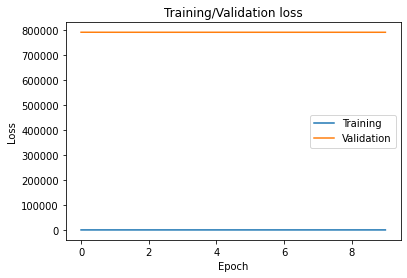

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_result[:, 2], label="Training")
plt.plot(train_result[:, 5]*450, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation loss")
plt.legend()
plt.savefig('lenet_loss.png')
plt.show()

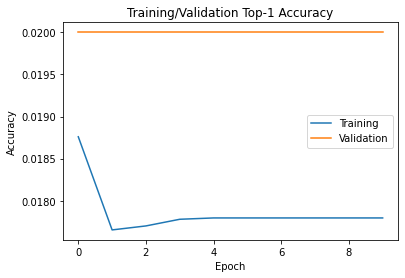

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_result[:, 0],label="Training")
plt.plot(train_result[:, 3],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation Top-1 Accuracy")
plt.legend()
plt.savefig('lenet_top1acc.png')
plt.show()

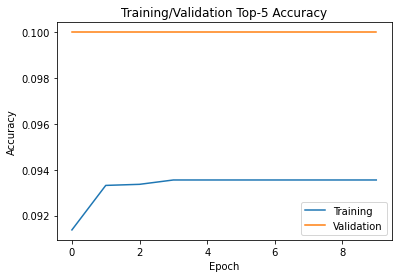

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_result[:, 1], label="Training")
plt.plot(train_result[:, 4], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training/Validation Top-5 Accuracy")
plt.legend()
plt.savefig('lenet_top5acc.png')
plt.show()

### FLOPs

In [24]:
import numpy as np

# 定義每個層的輸入大小和運算量
input_size = (1, 32, 32)  # 輸入圖像大小為32x32，單通道
conv1_output_size = (6, 28, 28)  # 第一個卷積層輸出大小為28x28，6個通道
conv2_output_size = (16, 10, 10)  # 第二個卷積層輸出大小為10x10，16個通道
fc1_output_size = 120  # 第一個全連接層的輸出大小
fc2_output_size = 84  # 第二個全連接層的輸出大小
output_size = 50  # 輸出層大小（類別數量）

# 計算每個層的乘加運算量
conv1_flops = input_size[0] * conv1_output_size[0] * conv1_output_size[1] * conv1_output_size[2] * 5 * 5  # 卷積核大小為5x5
conv2_flops = conv1_output_size[0] * conv2_output_size[0] * conv2_output_size[1] * conv2_output_size[2] * 5 * 5  # 卷積核大小為5x5
fc1_flops = conv2_output_size[0] * fc1_output_size
fc2_flops = fc1_output_size * fc2_output_size
output_flops = fc2_output_size * output_size

# 總乘加運算量
total_flops = conv1_flops + conv2_flops + fc1_flops + fc2_flops + output_flops

print("Total FLOPS: %.4f MFLOPs" % (total_flops / 1e6))


Total FLOPS: 0.3738 MFLOPs


### Space Complexity

In [35]:
def count_parameters(model):
    num_params = 0
    for layer in model.layers:
        if hasattr(layer, 'weight'):
            num_params += np.prod(layer.weight.shape)
        if hasattr(layer, 'bias'):
            num_params += np.prod(layer.bias.shape)
    return num_params

input_shape = (64, 1, 32, 32)
# net = LeNet5()

num_params = count_parameters(model)
print("Number of parameters: %.4f Million" %(num_params / 1e6))


Number of parameters: 0.0651 Million
